In [54]:
from __future__ import annotations
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [55]:
words: list[str] = open("names.txt", "r").read().splitlines()

In [56]:
# Gets all the characters, a-z
chars: list[str] = sorted(list(set("".join(words))))

# Maps each character to an integer
stoi: dict[str, int] = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0

# Maps each integer to a character
itos: dict[int, str] = {i: s for s, i in stoi.items()}

In [57]:
block_size = 3 # Context length: number of characters taken to predict the next one

# Build dataset
def build_dataset(words: list[str], print_examples: int = 0) -> tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
    for i, w in enumerate(words):
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if i < print_examples:
                print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    
    return torch.tensor(X), torch.tensor(Y)

In [58]:
X, Y = build_dataset(words, 5)

... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
... ----> a
..a ----> v
.av ----> a
ava ----> .
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [59]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

## MLP (Multilayer Perceptron)
![mlp](https://miro.medium.com/v2/resize:fit:1200/1*EqKiy4-6tuLSoPP_kub33Q.png)

In [60]:
# Embedding lookup table
C = torch.randn((27, 2))

In [61]:
# Parameters
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [62]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [63]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # Number of parameters in total

3481

In [64]:
# Forward pass
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [65]:
emb.view(-1, 6).shape

torch.Size([228146, 6])

In [66]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h)
h.shape

tensor([[ 0.9109, -0.9029,  0.9392,  ..., -0.9953,  0.9977,  0.5025],
        [ 0.8448, -0.9972,  0.9726,  ..., -0.7690, -0.0183, -0.4645],
        [ 0.8234,  0.7660,  0.5986,  ...,  0.8075, -0.8595, -0.2185],
        ...,
        [ 0.6319, -0.1280,  0.7909,  ..., -0.7100, -0.1661,  0.9806],
        [ 0.8249, -0.9734,  0.9716,  ..., -0.6130, -0.4013,  0.8645],
        [ 0.9574, -0.5757,  0.8919,  ..., -0.4815,  0.5580,  0.9927]])


torch.Size([228146, 100])

In [67]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [68]:
counts = logits.exp()
prob = counts / counts.sum(-1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [69]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(16.6923)

In [70]:
loss = F.cross_entropy(logits, Y)
loss

tensor(16.6923)

In [71]:
for p in parameters:
    p.requires_grad = True

In [72]:
# Learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [73]:
# Find optimal learning rate
lri = []
lossi = []

for i in range(1000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

7.598180770874023


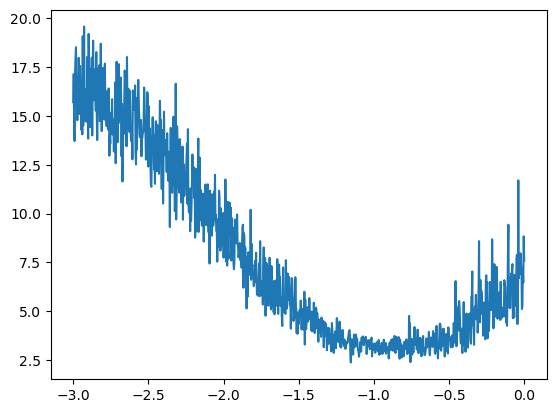

In [74]:
plt.plot(lri, lossi)

In [75]:
# Training
for i in range(10000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.5
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.060950994491577


In [76]:
# Create the data sets
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Training split (80%)
Xtr, Ytr = build_dataset(words[:n1])

# Dev/validation split (10%)
Xdev, Ydev = build_dataset(words[n1:n2])

# Test split (10%)
Xte, Yte = build_dataset(words[n2:])

In [77]:
# Parameters
C = torch.randn((27, 10))
W1 = torch.randn((30, 200))
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

In [78]:
# Training
for i in range(200000):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # Forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.863076090812683


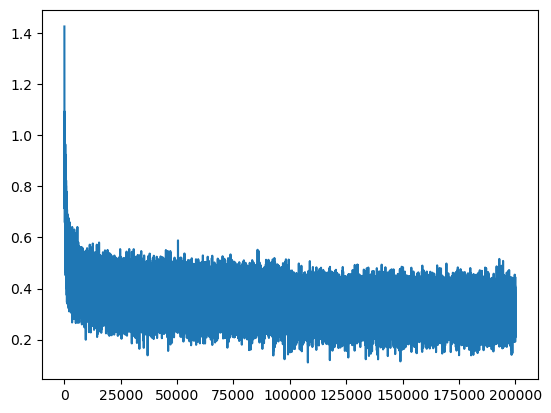

In [79]:
plt.plot(stepi, lossi)

In [80]:
# Evaluate training
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1196701526641846


In [81]:
# Evaluate dev
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.168586015701294


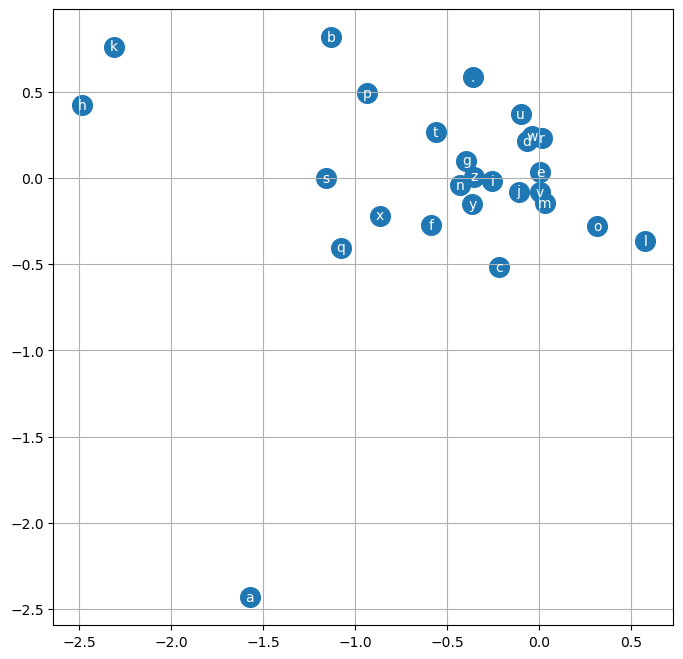

In [82]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [86]:
for _ in range(20):
    out = ""
    context = [0] * 3
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out += itos[ix]

    print(out)

kylienatosaliya
har
petina
aibelle
habwien
layah
lanilann
kariamoobiyah
llo
nikolahilla
irlyna
kella
gynakyn
fry
den
omalani
eyah
gymion
wjahmie
vene
